In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# garbage collector to free up memory
import gc
gc.enable()


In [ ]:
orders = pd.read_csv('/content/orders.csv' )
order_products_train = pd.read_csv('/content/order_products__train.csv')
order_products_prior = pd.read_csv('/content/order_products__prior.csv')
products = pd.read_csv('/content/products.csv')
aisles = pd.read_csv('/content/aisles.csv')
departments = pd.read_csv('/content/departments (1).csv')

In [ ]:
def reduce_mem_usage(train_data):
    
#  iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
              
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
        end_mem = train_data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data


In [ ]:
reduce_mem_usage(order_products_prior)
reduce_mem_usage(order_products_train)
reduce_mem_usage(products)
reduce_mem_usage(orders)
reduce_mem_usage(departments)
reduce_mem_usage(aisles)


Memory usage of dataframe is 188.67 MB
Memory usage after optimization is: 165.09 MB
Decreased by 12.5%
Memory usage after optimization is: 141.50 MB
Decreased by 25.0%
Memory usage after optimization is: 106.13 MB
Decreased by 43.7%
Memory usage after optimization is: 70.75 MB
Decreased by 62.5%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 36.97 MB
Decreased by 12.5%
Memory usage after optimization is: 31.69 MB
Decreased by 25.0%
Memory usage after optimization is: 22.45 MB
Decreased by 46.9%
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.33 MB
Decreased by 12.5%
Memory usage after optimization is: 2.52 MB
Decreased by -66.5%
Memory usage after optimization is: 2.24 MB
Decreased by -47.7%
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%
Memory usage of dataframe is 181.11 MB
Memory usage after optimization is: 168.18 MB
Decreased by 7.1%
Memory usage 

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [ ]:
# get shape of each df
print(f" aisles : {aisles.shape} \n depts : {departments.shape} \n order_prod_prior : {order_products_prior.shape} \n order_products_train : {order_products_train.shape} \n orders : {orders.shape} \n products : {products.shape}")

 aisles : (134, 2) 
 depts : (21, 2) 
 order_prod_prior : (6182314, 4) 
 order_products_train : (1384617, 4) 
 orders : (3391282, 7) 
 products : (49688, 4)


In [ ]:
# Helper functions to be able to correclty calculate the avergae of hours
# The problem is that if we deal with hours and average them normally, the average of 1:00 and 23:00 will be 12 not 0:00
import datetime
import math

def datetime_to_radians(x):
    # radians are calculated using a 24-hour circle, not 12-hour, starting at north and moving clockwise
    seconds_from_midnight = 3600 * x
    radians = float(seconds_from_midnight) / float(12 * 60 * 60) * 2.0 * math.pi
    return radians

def average_angle(angles):
    # angles measured in radians
    x_sum = np.sum(np.sin(angles))
    y_sum = np.sum(np.cos(angles))
    x_mean = x_sum / float(len(angles))
    y_mean = y_sum / float(len(angles))
    return np.arctan2(x_mean, y_mean)

def radians_to_time_of_day(x):
    # radians are measured clockwise from north and represent time in a 24-hour circle
    seconds_from_midnight = int(float(x) / (2.0 * math.pi) * 12.0 * 60.0 * 60.0)
    hour = seconds_from_midnight // 3600 % 24
    minute = (seconds_from_midnight % 3600) // 60
    second = seconds_from_midnight % 60
    return datetime.time(hour, minute, second)
    
def average_times_of_day(x):
    # input datetime.datetime array and output datetime.time value
    angles = [datetime_to_radians(y) for y in x]
    avg_angle = average_angle(angles)
    return radians_to_time_of_day(avg_angle)

def day_to_radians(day):
    radians = float(day) / float(7) * 2.0 * math.pi
    return radians
def radians_to_days(x):
    day = int(float(x) / (2.0 * math.pi) * 7) % 7
    return day
def average_days(x):
    angles = [day_to_radians(y) for y in x]
    avg_angle = average_angle(angles)
    return radians_to_days(avg_angle)


2. Predictor Features¶



2.1 User predictors

In [ ]:
# We keep only the prior orders
users = orders[orders['eval_set'] == 'prior']
users['days_since_prior_order'].dropna()

# We group orders by user_id & calculate the variables based on different user_id
users = users.groupby('user_id').agg(
    
 user_orders= ('order_number' , max),
 user_period=('days_since_prior_order', sum),
 user_mean_days_since_prior = ('days_since_prior_order','mean')
    
)
users.head()

,user_orders,user_period,user_mean_days_since_prior
user_id,,,
1.0,10.0,176.0,19.555555
2.0,14.0,198.0,15.230769
3.0,12.0,133.0,12.090909
4.0,5.0,55.0,13.750000
5.0,4.0,40.0,13.333333


calculate three more new variables:
user_total_products: Total numbers of basket items included in user's orders

user_reorder_ratio: Ratio a user orders reorordered products.

user_distinct_products: Total number of distinct products ordered

In [ ]:
# We create a new table "orders_products" which contains the tables "orders" and "order_products_prior"
orders_products =pd.merge(orders , order_products_prior, on='order_id', how='inner')

# Getting the number of products in each basket(order)
groupedorders_products = orders_products.groupby(['order_id']).agg(
    basket_size = ('product_id', 'count')
).reset_index()
orders_products = orders_products.merge(groupedorders_products, on='order_id', how='left')
orders_products.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,basket_size
0,473747,1.0,prior,3.0,3.0,12.0,21.0,196,1.0,1.0,5
1,473747,1.0,prior,3.0,3.0,12.0,21.0,12427,2.0,1.0,5
2,473747,1.0,prior,3.0,3.0,12.0,21.0,10258,3.0,1.0,5
3,473747,1.0,prior,3.0,3.0,12.0,21.0,25133,4.0,0.0,5
4,473747,1.0,prior,3.0,3.0,12.0,21.0,30450,5.0,0.0,5


In [ ]:
orders_products['p_reordered']= orders_products['reordered']==1
orders_products['non_first_order']= orders_products['order_number']>1

us=orders_products

# We group orders_products by user_id & calculate the variables based on different user_id
us=orders_products.groupby('user_id').agg(
    
     user_total_products =('user_id','count') ,
     p_reordered =('p_reordered', sum) ,
     non_first_order =('non_first_order', sum),
     user_distinct_products=('product_id','nunique')

).reset_index()
#    us['user_reorder_ratio'] = sum(reordered == 1) / sum(order_number > 1)
us['user_reorder_ratio']=us['p_reordered']/us['non_first_order']

del us["p_reordered"],us["non_first_order"]
del orders_products['p_reordered' ],orders_products['non_first_order']

us.head(20)


,user_id,user_total_products,user_distinct_products,user_reorder_ratio
0,1.0,18,10,0.722222
1,3.0,14,12,0.571429
2,4.0,2,2,0.000000
3,5.0,12,12,0.666667
4,6.0,7,7,0.285714
5,7.0,49,35,0.877551
6,8.0,21,21,NaN
7,9.0,30,30,NaN
8,10.0,76,66,0.197368
9,12.0,22,22,0.227273


Then we combine the users and us tables ussing inner_join() function and we calculate the final variable:
user_average_basket: Average number of basket item

In [ ]:
users =pd.merge(users,us ,on='user_id',  how='inner')

# We calculate the user_average_basket variable
users['user_average_basket'] = users['user_total_products'] / users['user_orders']
users.head()

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket
0,1.0,10.0,176.0,19.555555,18,10,0.722222,1.800000
1,3.0,12.0,133.0,12.090909,14,12,0.571429,1.166667
2,4.0,5.0,55.0,13.750000,2,2,0.000000,0.400000
3,5.0,4.0,40.0,13.333333,12,12,0.666667,3.000000
4,6.0,3.0,18.0,9.000000,7,7,0.285714,2.333333


We now identify the future order per user and add them in the users table. The future orders are indicated as train and test in the eval_set variable. As a result, we will know what is the order_id of the future order per user, whether this order belongs in the train or test set, and the time in days since the last order.


In [ ]:
# we exclude prior orders and thus we keep only train and test orders
us = orders[orders['eval_set'] != 'prior']
us['time_since_last_order'] = us['days_since_prior_order']
us['future_order_dow'] = us['order_dow']
us['future_order_hour_of_day'] = us['order_hour_of_day']

us = us[['user_id','order_id','eval_set','time_since_last_order', 'future_order_dow', 'future_order_hour_of_day']]

# We combine users and us tables and store the results into the users table
users_features = pd.merge(users , us, on='user_id', how='inner') 

# We delete the us table
del us, users

users_features.head()



<ipython-input-40-c63a1a03c79d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['time_since_last_order'] = us['days_since_prior_order']
<ipython-input-40-c63a1a03c79d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['future_order_dow'] = us['order_dow']
<ipython-input-40-c63a1a03c79d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,future_order_dow,future_order_hour_of_day
0,1.0,10.0,176.0,19.555555,18,10,0.722222,1.800000,1187899,train,14.0,4.0,8.0
1,3.0,12.0,133.0,12.090909,14,12,0.571429,1.166667,2774568,test,11.0,5.0,15.0
2,4.0,5.0,55.0,13.750000,2,2,0.000000,0.400000,329954,test,30.0,3.0,12.0
3,5.0,4.0,40.0,13.333333,12,12,0.666667,3.000000,2196797,train,6.0,0.0,11.0
4,6.0,3.0,18.0,9.000000,7,7,0.285714,2.333333,1528013,test,22.0,3.0,16.0


2.2 Product dependent Features
Total number of orders per product
Avg position in cart for the product


In [ ]:
prod_features = orders_products.groupby(['product_id']).agg(
    prod_freq = ('order_id', 'count'),
    prod_avg_position = ('add_to_cart_order', 'mean')
    ,prod_avg_hour = ('order_hour_of_day', average_times_of_day),
    prod_avg_dow = ('order_dow', average_days)
).reset_index()

prod_features.head(20)

,product_id,prod_freq,prod_avg_position,prod_avg_hour,prod_avg_dow
0,1,347,5.953890,23:56:56,2
1,2,16,13.312500,03:23:07,0
2,3,32,6.968750,03:33:22,0
3,4,63,9.190476,01:12:46,0
4,5,4,5.500000,22:30:00,0
5,6,4,12.750000,01:29:59,0
6,7,2,6.000000,02:30:00,0
7,8,25,9.360000,18:39:36,0
8,9,31,9.225806,19:48:38,0
9,10,465,8.604301,22:50:05,6


Probability a product is reordered after the first order
On average how many times a product has been purchased by the users who purchased it at least once

In [ ]:
non_first_order = orders_products['order_number'] != 1

groupedorders_products = orders_products[non_first_order].groupby(['product_id']).agg(
    prod_reorder_ratio = ('reordered', 'mean')
).reset_index()

prod_features = prod_features.merge(groupedorders_products, on='product_id', how='left')

# Group by users who have bought it more than once
# get the count of orders each user bought having the product. 
groupedorders_products = orders_products[non_first_order].groupby(['product_id', 'user_id']).agg(
    user_prod_freq = ('order_id', 'count')
).reset_index()

# get the avg # of orders the user will buy having that product after buying it for the first time
groupedorders_products = groupedorders_products.groupby(['product_id']).agg(
    user_prod_avg_freq = ('user_prod_freq', 'mean')
).reset_index()

prod_features = prod_features.merge(groupedorders_products, on='product_id', how='left')
del groupedorders_products, non_first_order

prod_features.head()



,product_id,prod_freq,prod_avg_position,prod_avg_hour,prod_avg_dow,prod_reorder_ratio,user_prod_avg_freq
0,1,347,5.953890,23:56:56,2,0.625767,1.455357
1,2,16,13.312500,03:23:07,0,0.066667,1.000000
2,3,32,6.968750,03:33:22,0,0.793103,1.450000
3,4,63,9.190476,01:12:46,0,0.561404,1.266667
4,5,4,5.500000,22:30:00,0,1.000000,2.000000


2.3 User x Product Predictors
We now create predictors that indicate how a user behaves towards a specific product. We store these predictors in the data table, which is also the final table that we create. Towards this end, we use both prd and users tables.
We start by calculating four new variables:
up_orders:The total times a user ordered a product

up_first_order: What was the first time a user purchased a product

up_last_order: What was the last time a user purchased a product

up_average_cart_position: The average position in a user's cart of a product

In [ ]:
# We create the data table starting from the orders_products table 
data = orders_products

data = data.groupby(['user_id','product_id']).agg(

 up_orders= ('product_id', 'count'),
 up_first_order=('order_number', min),
 up_last_order = ('order_number',max),
 up_average_cart_position = ('add_to_cart_order','mean')
 ,up_avg_hour = ('order_hour_of_day', average_times_of_day),
 up_avg_dow = ('order_dow', average_days)
).reset_index()
 
del orders_products
data.head(20)

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,up_avg_hour,up_avg_dow
0,1.0,196,3,3.0,7.0,1.000000,00:00:00,2
1,1.0,10258,3,3.0,7.0,2.666667,00:00:00,2
2,1.0,10326,1,5.0,5.0,5.000000,02:59:59,4
3,1.0,12427,3,3.0,7.0,2.333333,00:00:00,2
4,1.0,13032,1,7.0,7.0,5.000000,21:00:00,1
5,1.0,13176,1,5.0,5.0,8.000000,02:59:59,4
6,1.0,17122,1,5.0,5.0,6.000000,02:59:59,4
7,1.0,25133,3,3.0,7.0,4.000000,00:00:00,2
8,1.0,30450,1,3.0,3.0,5.000000,00:00:00,3
9,1.0,41787,1,5.0,5.0,7.000000,02:59:59,4


Then We compine the data table with the prd and users tables and we calculate the final three variables.
up_order_rate: Percentage of user’s orders that include a specific product

up_orders_since_last_order: Number of orders since user’s last order of a product

up_order_rate_since_first_order: Pecentage of orders since first order of a product in which a user purchased this product



In [ ]:
# up_order_rate = up_orders / user_total_products
data = data.merge(users_features[['user_id','user_orders']], on='user_id' , how='left')
data['up_order_rate'] = data['up_orders']/data['user_orders']

# up_orders_since_last_order = user_last_order - user_last_ordered_that_product
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']

# From the moment the user know about the product, how frequent he then bought it in his next orders?
# up_order_rate_since_first_order = up_orders / (user_orders - up_first_order + 1)
# The + 1 is added since order_numbering starts from 1 not 0
data['up_order_rate_since_first_order'] = data['up_orders']/(data['user_orders'] - data['up_first_order'] + 1)
del data['user_orders']

data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,up_avg_hour,up_avg_dow,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order
0,1.0,196,3,3.0,7.0,1.000000,00:00:00,2,0.3,3.0,0.375000
1,1.0,10258,3,3.0,7.0,2.666667,00:00:00,2,0.3,3.0,0.375000
2,1.0,10326,1,5.0,5.0,5.000000,02:59:59,4,0.1,5.0,0.166667
3,1.0,12427,3,3.0,7.0,2.333333,00:00:00,2,0.3,3.0,0.375000
4,1.0,13032,1,7.0,7.0,5.000000,21:00:00,1,0.1,3.0,0.250000


It seems that user_id = 1 is always ordering product


Merging product, user, product-user features

In [ ]:
# Merging user and product features with the final features dataframe
data = data.merge(users_features, on='user_id', how='left').merge(prod_features, on='product_id', how='left')
del users_features, prod_features

order_products_future = order_products_train.merge(orders, on='order_id', how='left')
order_products_future = order_products_future[['user_id', 'product_id', 'reordered']]
data = data.merge(order_products_future, on=['user_id', 'product_id'], how='left')

# Set 0 to Product who didn't exists in the future order so model can predict them as Not in future order.
data['reordered'].fillna(0, inplace = True)

2.4 Time-dependent Predictors
2.4.1 User-dependent
On avg the hour the user buys this product at - The future order hour.
On avg which day of week the user buys this product at - The future order's day of week. #### 2.4.2 product-dependent
On avg the hour the product is most bought at - The future order hour.
On avg which day of week the product is most bought at - The future order's day of week
Frequency of buying this product at the future's order hour of day. [Not yet implemented]
Frequency of buying this product on the future's order day of week. [Not yet implemented]

In [ ]:
'''
Calculates the difference between 2 values from a looping sequence
dist(X, Y) = min { X-Y, N-(X-Y) }
'''
def diff_bet_time(arr1, arr2, max_value=23):
    arr1 = pd.to_datetime(arr1, format='%H')
    arr2 = pd.to_datetime(arr2, format='%H:%M:%S')
    arr_diff = np.abs(arr1.dt.hour-arr2.dt.hour)
    return np.minimum(arr_diff, max_value- (arr_diff-1))

'''
Calculates the difference between 2 values from a looping sequence
dist(X, Y) = min { X-Y, N-(X-Y) }
'''
def diff_bet_dow(arr1, arr2, max_value=6):
    arr_diff = np.abs(arr1-arr2)
    return np.minimum(arr_diff, max_value- (arr_diff-1))

In [ ]:
data['up_hour_diff'] = diff_bet_time(data['future_order_hour_of_day'], data['up_avg_hour'])
data['up_dow_diff'] = diff_bet_dow(data['future_order_dow'], data['up_avg_dow'])

data['prod_hour_diff'] = diff_bet_time(data['future_order_hour_of_day'], data['prod_avg_hour'], )
data['prod_dow_diff'] = diff_bet_dow(data['prod_avg_dow'], data['future_order_dow'])

del data['prod_avg_dow'], data['prod_avg_hour'], data['future_order_hour_of_day'], data['up_avg_hour'], data['future_order_dow'], data['up_avg_dow']
# del data['future_order_hour_of_day'], data['future_order_dow']

# # Saving features in a csv file
# data.to_csv('./features.csv', index=False)

Creating the X, y

# To saveup memory, delete any dataframe we won't use next
del order_products_prior, order_products_train, products, orders, departments, aisles

Splitting data to train, valid and test
Note that we don't have y_test, since in the data given we don't know what products will be in the test future orders.
To have an direction on how our model performs, will create a validation set.
Train on train set, observe performance and tune parameters on valid set.


In [ ]:
# Splitting data to train and test
X_train = data[data['eval_set'] == 'train']
y_train = X_train['reordered']
X_test = data[data['eval_set'] == 'test']
del data


In [ ]:
from sklearn.model_selection import train_test_split

print('Class distribution before splitting')
pos_count = np.sum(X_train['reordered']==1)
neg_count = np.sum(X_train['reordered']==0)
print('positive ratio: ', pos_count)
print('negative count: ', neg_count)
print('positive ratio: ', pos_count/(pos_count+neg_count))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
print('Class distribution of Train set')
train_pos_count = np.sum(X_train['reordered']==1)
train_neg_count = np.sum(X_train['reordered']==0)
print('positive count: ', train_pos_count)
print('negative count: ', train_neg_count)
print('positive ratio: ', train_pos_count/(train_pos_count+train_neg_count))

print('Class distribution of Validation set')
val_pos_count = np.sum(X_val['reordered']==1)
val_neg_count = np.sum(X_val['reordered']==0)
print('positive count: ', val_pos_count)
print('negative count: ', val_neg_count)
print('positive ratio: ', val_pos_count/(val_pos_count+val_neg_count))


Class distribution before splitting
positive ratio:  404385
negative count:  2310418
positive ratio:  0.14895555957467263
Class distribution of Train set
positive count:  283352
negative count:  1617010
positive ratio:  0.14910422330061326
Class distribution of Validation set
positive count:  121033
negative count:  693408
positive ratio:  0.14860867760832278


In [ ]:
# Removing eval_set and the target variable from features
X_train_non_pred_vars = X_train[['product_id', 'order_id', 'user_id']]
X_train.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

X_val_non_pred_vars = X_val[['product_id', 'order_id', 'user_id']]
X_val.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

X_test_non_pred_vars = X_test[['product_id', 'order_id', 'user_id']]
X_test.drop(['reordered', 'eval_set', 'product_id', 'order_id', 'user_id'], axis=1, inplace=True)

# Drop features I suspect redundant or of no significant importance as the feature importance graph says
X_train.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)
X_test.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)
X_val.drop(['up_orders', 'up_last_order', 'user_total_products', 'user_distinct_products'], axis=1, inplace=True)

# Dropping the time dependent features 'up_dow_diff','prod_dow_diff','up_hour_diff','prod_hour_diff'
# We had a strong intuition that these time features will be significant in the prediction,
# However, they were the least feature's importance used by the model.
# This is why We commented them across the code.

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(1900362, 19) (1900362,)
(814441, 19) (814441,)
(1550045, 19)


In [ ]:
X_train.columns

Index(['up_first_order', 'up_average_cart_position', 'up_order_rate',
       'up_orders_since_last_order', 'up_order_rate_since_first_order',
       'user_orders', 'user_period', 'user_mean_days_since_prior',
       'user_reorder_ratio', 'user_average_basket', 'time_since_last_order',
       'prod_freq', 'prod_avg_position', 'prod_reorder_ratio',
       'user_prod_avg_freq', 'up_hour_diff', 'up_dow_diff', 'prod_hour_diff',
       'prod_dow_diff'],
      dtype='object')

Training the Model

Notes from xgb documentation

learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
max_depth: determines how deeply each tree is allowed to grow during any boosting round.
subsample: percentage of samples used per tree. Low value can lead to underfitting.
colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
n_estimators: number of trees you want to build.
objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability. XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
alpha: L1 regularization on leaf weights. A large value leads to more regularization.
lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [ ]:
from sklearn import preprocessing
# Standarization didn't affect the score much
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(1900362, 19)
(1550045, 19)
(814441, 19)


In [ ]:
# y_train = y_train.values.reshape(-1)


In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
#         # Define the correct function signature for on_epoch_end
#         def on_epoch_end(self, epoch, logs={}):
#             if logs.get('recall') is not None and logs.get('recall') > 0.8: 
#                 print("\nReached 80% recall so cancelling training!") 
                
#                 # Stop training once the above condition is met
#                 self.model.stop_training = True

# callbacks = myCallback()
# # Build the classification model
# model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
#                                     tf.keras.layers.Dense(128, activation=tf.nn.relu),
#                                     tf.keras.layers.Dense(128, activation=tf.nn.relu),
#                                     tf.keras.layers.Dense(1, activation=tf.nn.softmax)])
# model.compile(optimizer='adam', 
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
#                   metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# history = model.fit(x=X_train, y=y_train, epochs=10, callbacks=[callbacks])

In [ ]:
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_train.shape


(1900362,)

In [ ]:
import xgboost as xgb
from sklearn import metrics

# Training the model with features except the product_id, user_id, order_id columns
clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.4, learning_rate = 0.1,
                max_depth = 5, reg_lambda = 5.0, n_estimators = 100)
clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

[0.02850397 0.02590846 0.12577948 0.13219176 0.13467008 0.0400303
 0.0175013  0.01534501 0.08183786 0.00824416 0.03306471 0.02902069
 0.04597137 0.09575998 0.15438108 0.00455887 0.01489957 0.00337719
 0.00895414]


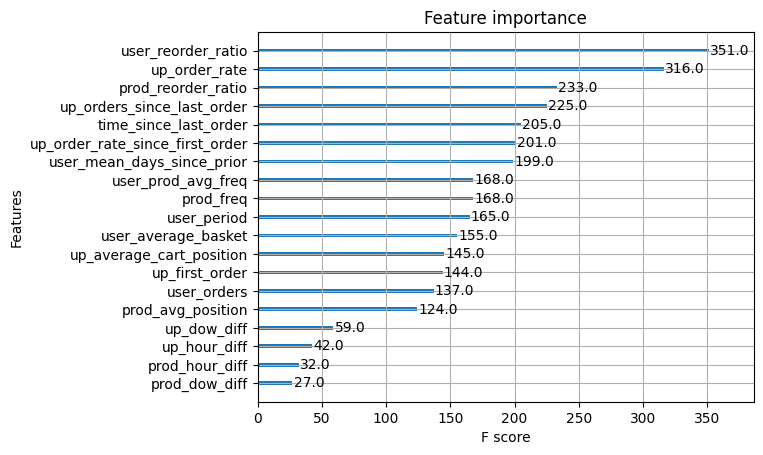

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
# Visualizing the Feature importance 
print(clf.feature_importances_)

xgb.plot_importance(clf)
plt.show()

Analyzing PR-Curve

In [ ]:
# keep probabilities for the positive outcome only
y_test_prob = clf.predict_proba(X_test)[:, 1]
y_val_prob = clf.predict_proba(X_val)[:, 1]
y_train_prob = clf.predict_proba(X_train)[:, 1]

In [ ]:
'''
This function maximizes a metric, while keeping another metric above a given threshold.
'''
def maximize_metric_keep_metric(metric1_list, metric2_list, metric2_thresh=0.3):
    for idx in range(len(metric1_list)):
        if(metric2_list[idx] > metric2_thresh):
            return idx
    return -1

In [ ]:
from sklearn.metrics import precision_recall_curve

# Choosing Threshold that maximizes the f1_score
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)
f1_scores = 2*recall*precision/(recall+precision)
opt_indx = np.argmax(f1_scores)
print("Maximuim f1_score for the positive class: ", f1_scores[opt_indx])
print("Correspoding precision: ", precision[opt_indx])
print("Correspoding recall: ", recall[opt_indx])
print("Correspoding Threshold: ", thresholds[opt_indx])
best_thresh = thresholds[opt_indx]

Maximuim f1_score for the positive class:  0.4279320516732784
Correspoding precision:  0.36288722634663045
Correspoding recall:  0.5213867292391331
Correspoding Threshold:  0.22135058


In [ ]:
# Choosing Threshold that maximizes recall, while keeping precision above 0.3
opt_indx = maximize_metric_keep_metric(metric1_list=recall, metric2_list=precision, metric2_thresh=0.3)
print("Max recall for the positive class: ", recall[opt_indx])
print("Correspoding precision: ", precision[opt_indx])
print("Correspoding f1_score: ", f1_scores[opt_indx])
print("Correspoding Threshold: ", thresholds[opt_indx])
best_thresh = thresholds[opt_indx]

Max recall for the positive class:  0.6712962580453264
Correspoding precision:  0.3000011077100311
Correspoding f1_score:  0.4146816991696057
Correspoding Threshold:  0.16062982


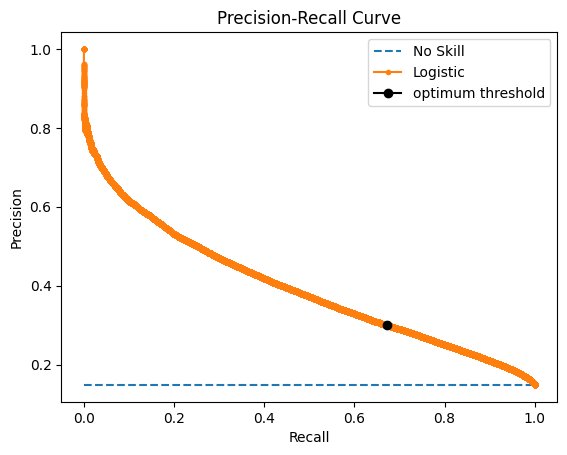

In [ ]:
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.plot(recall[opt_indx], precision[opt_indx], marker='o', color='k', label='optimum threshold')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

Dynamic Thresholding

In [ ]:
def recommended_basket(user_prods):
    user_basket_size = int(np.floor(user_prods['user_average_basket'].iloc[0]))
    user_prods = user_prods.sort_values(by=['reordered_prop'], ascending=False)
    user_prods.iloc[:user_basket_size]['reordered'] = 1
    user_prods.iloc[user_basket_size:]['reordered'] = 0

In [ ]:
# Changing probabilities to crisp predicted values, useing the threshold obtained from the ROC-curve
y_test_preds = y_test_prob>best_thresh
y_val_preds = y_val_prob>best_thresh
y_train_preds = y_train_prob>best_thresh

Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('-----------------CLASSIFICATION REPORT--------------------')
print("Train positive class count: ", y_train.sum())
print("Train negative class count: ", y_train.shape[0] - y_train.sum())
print("Train Set tn, fp, fn, tp:",confusion_matrix(y_train, y_train_preds).ravel())
print("Train Set report:",classification_report(y_train, y_train_preds))

print("Validation positive class count: ", y_val.sum())
print("Validation negative class count: ", y_val.shape[0] - y_val.sum())
print("Validation Set tn, fp, fn, tp:",confusion_matrix(y_val, y_val_preds).ravel())
print("Validation Set report:",classification_report(y_val, y_val_preds))


-----------------CLASSIFICATION REPORT--------------------
Train positive class count:  283352.0
Train negative class count:  1617010.0
Train Set tn, fp, fn, tp: [1176349  440661   92362  190990]
Train Set report:               precision    recall  f1-score   support

         0.0       0.93      0.73      0.82   1617010
         1.0       0.30      0.67      0.42    283352

    accuracy                           0.72   1900362
   macro avg       0.61      0.70      0.62   1900362
weighted avg       0.83      0.72      0.76   1900362

Validation positive class count:  121033.0
Validation negative class count:  693408.0
Validation Set tn, fp, fn, tp: [503829 189579  39784  81249]
Validation Set report:               precision    recall  f1-score   support

         0.0       0.93      0.73      0.81    693408
         1.0       0.30      0.67      0.41    121033

    accuracy                           0.72    814441
   macro avg       0.61      0.70      0.61    814441
weighted avg     

In [ ]:
import csv

# Append prediction to test_order details
test_orders = X_test_non_pred_vars[['user_id','order_id','product_id']]
test_orders['reordered'] = y_test_preds

# Extracting orders who have no predicted products
empty_orders = test_orders.groupby(['order_id']).agg(
    count_reorders = ('reordered', 'sum')
).reset_index()
empty_orders = empty_orders[empty_orders['count_reorders'] == 0]

# For orders who have predicted products 
# Extract the products predicted to be in the future order
test_orders = test_orders[test_orders['reordered'] == 1]
# For each order group its predicted products together into a list 
test_orders = test_orders.groupby('order_id')['product_id'].apply(list).reset_index(name='products')

test_orders.head()

<ipython-input-68-cbc053b27d30>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_orders['reordered'] = y_test_preds


,order_id,products
0,17.0,"[21709, 47766]"
1,34.0,"[9839, 21463, 39180, 39475, 43504, 44663, 4491..."
2,137.0,"[23794, 24852, 30142, 38689, 41787, 43352]"
3,182.0,"[5479, 9337, 26128, 31737, 33000, 33198, 39275..."
4,257.0,"[13176, 24852, 27966, 28476, 28985, 29837, 302..."


In [ ]:
# csv header
headerNames = ['order_id', 'products', 'user_id']
rows = []

for index, row in test_orders.iterrows():
    products = ' '.join(str(product_id) for product_id in row['products']) 
    rows.append( 
        {'order_id': str(row['order_id']),
         'products': products})

for index, row in empty_orders.iterrows():
    rows.append( 
        {'order_id': str(row['order_id']),
         'products': 'None'})
    
with open('./submissions.csv', 'w', encoding='UTF-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=headerNames)
    writer.writeheader()
    writer.writerows(rows)